# Trabajo Práctico 1

## Métricas custom para reducción de falsos positivos en clasificación binaria fraude

### 1. EDA

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv("data/dataset_feature_engineering.csv")
dataset

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,first_time_at_merchant,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,...,True,78.773821,1,1,0,2019,5,4,2,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,...,True,30.216618,1,1,0,2019,4,4,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,...,True,108.102912,1,1,0,2019,4,3,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,...,True,95.685115,1,1,0,2019,1,1,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,...,True,77.702395,1,1,0,2019,6,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,MO,...,False,77.032467,12,3,23,2020,6,3,1,1
1852390,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,...,False,100.023736,12,3,23,2020,5,3,1,1
1852391,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,...,False,80.887812,12,3,23,2020,10,7,1,2
1852392,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,...,False,53.060882,12,3,23,2020,4,2,2,1


In [3]:
dataset.shape

(1852394, 35)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 35 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cc_num                           int64  
 1   merchant                         object 
 2   category                         object 
 3   amt                              float64
 4   first                            object 
 5   last                             object 
 6   gender                           object 
 7   street                           object 
 8   city                             object 
 9   state                            object 
 10  zip                              int64  
 11  lat                              float64
 12  long                             float64
 13  city_pop                         int64  
 14  job                              object 
 15  dob                              object 
 16  trans_num                        object 
 17  unix_tim

In [5]:
dataset.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,...,count_month_shopping_net,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,...,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03,...,4.567241e+00,7.610956e+01,7.152067e+00,2.967456e+00,1.280612e+01,2.019501e+03,5.298079e+00,3.150459e+00,1.389109e+00,1.655442e+00
std,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02,...,4.575502e+00,2.909273e+01,3.424954e+00,2.197983e+00,6.815753e+00,4.999996e-01,3.094345e+00,1.865369e+00,6.722559e-01,9.025901e-01
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00,...,0.000000e+00,2.227351e-02,1.000000e+00,0.000000e+00,0.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00,...,1.000000e+00,5.534198e+01,4.000000e+00,1.000000e+00,7.000000e+00,2.019000e+03,3.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00
50%,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00,...,3.000000e+00,7.824823e+01,7.000000e+00,3.000000e+00,1.400000e+01,2.020000e+03,5.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00
75%,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00,...,7.000000e+00,9.847204e+01,1.000000e+01,5.000000e+00,1.900000e+01,2.020000e+03,7.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00
max,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00,...,4.800000e+01,1.518682e+02,1.200000e+01,6.000000e+00,2.300000e+01,2.020000e+03,2.800000e+01,1.700000e+01,9.000000e+00,9.000000e+00


#### Análisis de distribución y balanceo de clases.

Se puede observar que la distribución de la información clasificada como fraude es muy disproporcional. El 99.48% de los datos son no fraude y el 0.52% son fraude. Esto puede llevar a un modelo que prediga siempre no fraude, obteniendo una alta precisión pero sin ser útil en la detección de fraudes.

In [7]:
dataset["is_fraud"].value_counts()

is_fraud
0    1842743
1       9651
Name: count, dtype: int64

In [8]:
dataset["is_fraud"].value_counts(normalize=True) * 100

is_fraud
0    99.478999
1     0.521001
Name: proportion, dtype: float64

<Axes: xlabel='is_fraud'>

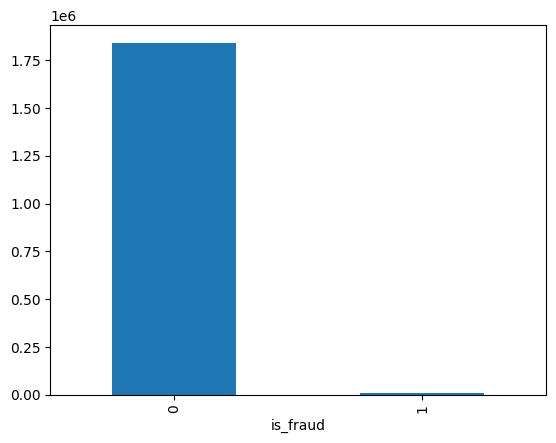

In [9]:
dataset["is_fraud"].value_counts().plot(kind="bar")

In [10]:
# Correlación
numeric_df = dataset.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

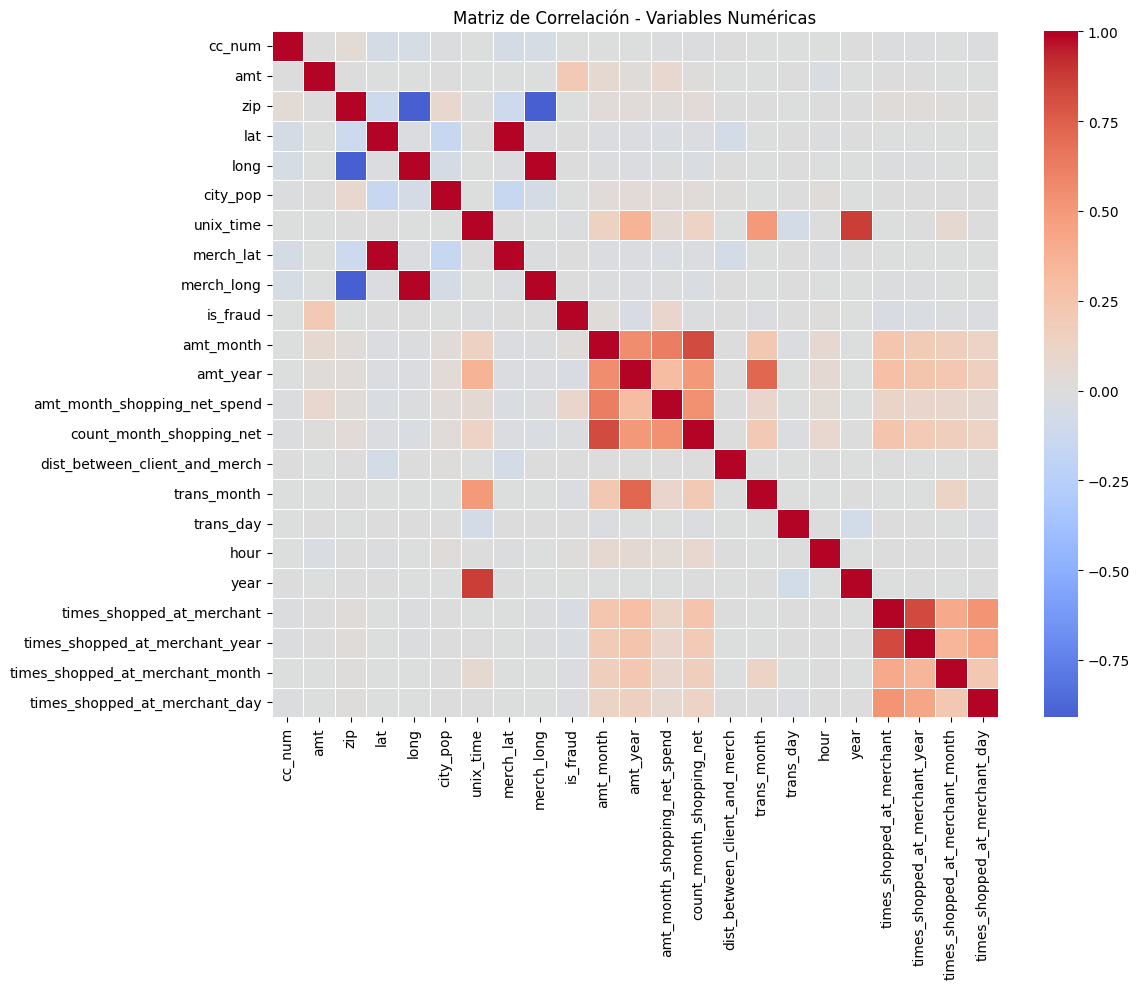

In [11]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, annot=False, fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación - Variables Numéricas")
plt.tight_layout()
plt.show()

In [13]:
is_fraud_corr = correlation_matrix["is_fraud"].sort_values(ascending=False)
print("Correlación de variables con is_fraud:\n", is_fraud_corr)

Correlación de variables con is_fraud:
 is_fraud                           1.000000
amt                                0.209308
amt_month_shopping_net_spend       0.099671
amt_month                          0.021675
hour                               0.013196
trans_day                          0.004562
lat                                0.002904
merch_lat                          0.002778
long                               0.001022
merch_long                         0.000999
dist_between_client_and_merch      0.000362
city_pop                           0.000325
cc_num                            -0.001125
zip                               -0.002190
year                              -0.006022
count_month_shopping_net          -0.012130
times_shopped_at_merchant_month   -0.012262
unix_time                         -0.013329
times_shopped_at_merchant_day     -0.016065
trans_month                       -0.016417
times_shopped_at_merchant_year    -0.025434
times_shopped_at_merchant         -0

In [14]:
top_features = is_fraud_corr.drop("is_fraud").abs().sort_values(ascending=False).head(5).index.tolist()
print("Top 5 variables más correlacionadas con is_fraud:", top_features)

Top 5 variables más correlacionadas con is_fraud: ['amt', 'amt_month_shopping_net_spend', 'amt_year', 'times_shopped_at_merchant', 'times_shopped_at_merchant_year']


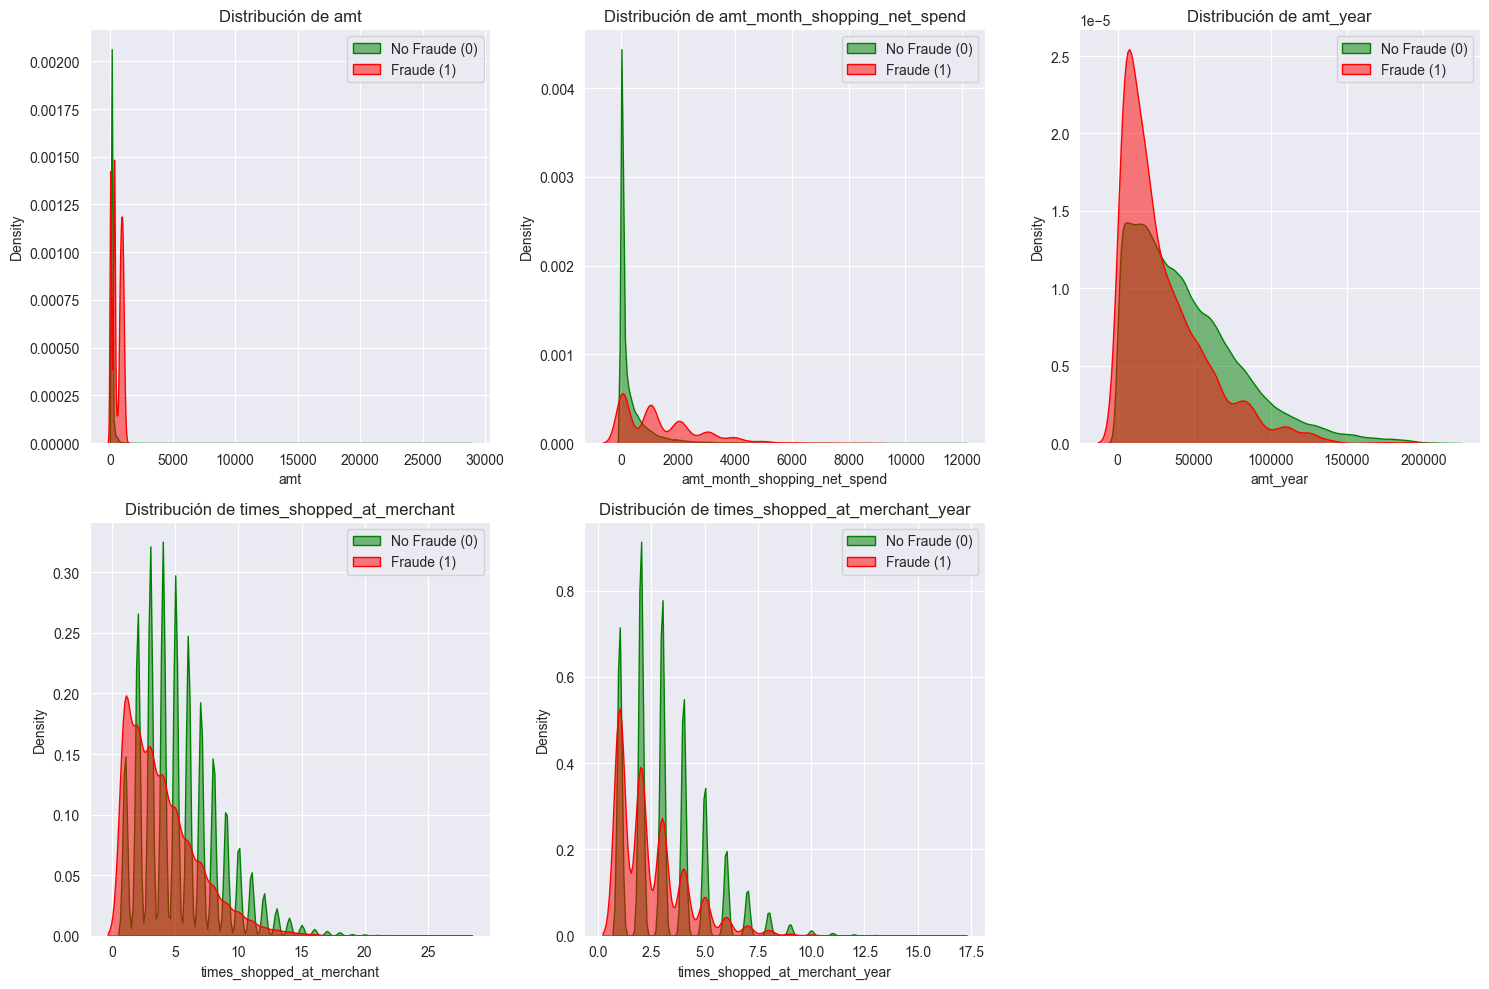

In [15]:
plt.figure(figsize=(15, 10))

for i, feature in enumerate(top_features):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(data=dataset[dataset["is_fraud"] == 0], x=feature, label="No Fraude (0)", fill=True, color="green", alpha=0.5)
    sns.kdeplot(data=dataset[dataset["is_fraud"] == 1], x=feature, label="Fraude (1)", fill=True, color="red", alpha=0.5)
    plt.title(f"Distribución de {feature}")
    plt.legend()

plt.tight_layout()
plt.show()